## Baseline: Sunday as holiday

In [2]:
import os
import datetime

import numpy as np
import pandas as pd
import geopandas as gpd

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline 

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import notebook_utils

In [3]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../src')

from helpers import api, data_utils

In [4]:
MODEL_NAME = 'baseline_sunday'
N_PRED_DAYS = 7
groups = ['unseen', 'embeddings', 'nonselected']
time = pd.to_datetime('2019-04-15')
test_end_time = time + pd.DateOffset(days = N_PRED_DAYS)

In [5]:
link_refs = {}
for group in groups:
    with open(f'../output/links_{group}.txt') as f:
        link_refs_ = f.readlines()
        link_refs[group] = list(filter(lambda x: not x.startswith('#'), [x.strip() for x in link_refs_]))

In [6]:
cal = api.calendar(from_date=time, to_date=test_end_time)

loading https://vehicletracker-api.azurewebsites.net/api/services/calendar?fromDate=2019-04-15T00:00:00&toDate=2019-04-22T00:00:00


In [7]:
cal

,weekday,day_type,statutory_holiday
date,,,
2019-04-15,Monday,Pre Easter Monday,False
2019-04-16,Tuesday,Pre Easter Tuesday,False
2019-04-17,Wednesday,Pre Easter Wednesday,False
2019-04-18,Thursday,Maundy Thursday,True
2019-04-19,Friday,Good Friday,True
2019-04-20,Saturday,Saturday,False
2019-04-21,Sunday,Easter Day,True


In [8]:
for group in groups:
    for link_ref in link_refs[group]:
        pass #api.train(link_ref = link_ref, model = 'ha', time = '2019-04-15')

In [11]:
time_slug = time.date().isoformat().replace('-', '')

test = {}
for group in groups:    
    for link_ref in link_refs[group]:        
        
        link_ref_slug = link_ref.replace(':', '-')        
        output_directory = f'../output/{MODEL_NAME}/{group}/{link_ref_slug}'
        if not os.path.exists(output_directory):
            os.makedirs(output_directory)

        test[link_ref] = api.link_travel_time(link_ref, from_time=time, to_time=test_end_time)
        test[link_ref]['link_travel_time_exp'] = test[link_ref].rolling(window=20, center=True, min_periods=1)['link_travel_time'].mean().round(1)
        holidays = np.isin(test[link_ref].index.date, cal[cal['statutory_holiday']].index.date)
        time_ix = test[link_ref].index.values.copy()
        time_ix[holidays] += cal[cal['weekday'] == 'Sunday'].index.values[0] - pd.to_datetime(test[link_ref].index[holidays].date)
        test[link_ref][MODEL_NAME] = api.predict(link_ref, model = 'ha', time=time_ix, verbose=False)['predicted'].values        
        #test[link_ref][MODEL_NAME] = test[link_ref].rolling(window=20, center=True, min_periods=1)[MODEL_NAME].mean().round(1)
        test[link_ref].to_csv(f"{output_directory}/test_{time_slug}.csv")

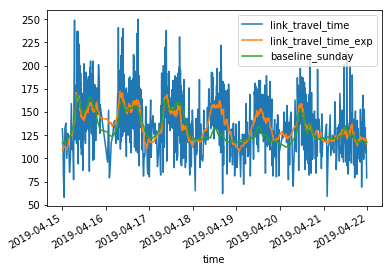

In [10]:
test['1193:2666'].plot()